In [1]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs_fdbck_clean.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar
import seaborn as sns
import numpy as np

import pandas as pd

from bs_fdbck_clean.constants import path_measurement_data

%load_ext autoreload
%autoreload 2

from bs_fdbck_clean.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod
 
xr.set_options(keep_attrs=True) 

import numpy as np

import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/bs_fdbck_clean/data_info


In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## SET SEASON

In [3]:
season = 'MAM'

### Filename for saved plots

In [4]:
def make_fn(case, v_x, v_y, comment='', relplot = False, distplot=False):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'cloud_props_{comment}_{case}_{_x}_{_y}_{season}.png'
    if relplot:
        return plot_path_relplot/f
    if distplot:
        return plot_path_distplot/f

    return plot_path /f




plot_path = Path('Plots')
plot_path.mkdir(parents=True, exist_ok=True) 

plot_path_distplot = plot_path/'dist_plot'
plot_path_distplot.mkdir(parents=True, exist_ok=True) 

plot_path_relplot = plot_path/'rel_plot'
plot_path_relplot.mkdir(parents=True, exist_ok=True) 

## Load observational data

## LOAD MY VERSION OF SATELLITE: 

In [5]:
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
from pathlib import Path 
import time
import netCDF4

In [6]:
rn_dic = {
    'Cloud_Optical_Thickness_Liquid_Mean':'COT',
    'Cloud_Effective_Radius_Liquid_Mean': 'r_eff',
    'Cloud_Water_Path_Liquid_Mean': 'CWP',
}

In [7]:
produce_files = [
    'Cloud_Optical_Thickness_Liquid_Mean', 
    'Cloud_Effective_Radius_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean_Uncertainty',
    'Cloud_Water_Path_Liquid_Standard_Deviation',
    'Cloud_Water_Path_Liquid_Maximum',
    'Cloud_Water_Path_Liquid_Minimum',
]

In [8]:
from bs_fdbck_clean.constants import path_measurement_data

## Settings: 

In [9]:
# path_raw_data = path_measurement_data /'satellite' / 'MODIS_raw'

# path_out_netcdf = path_measurement_data /'satellite' / 'MODIS_netcdf'


path_out_postproc = path_measurement_data /'satellite' / 'MODIS_postproc'
path_out_postproc_lev2 = path_measurement_data /'satellite' / 'MODIS_postproc_lev2'

station = 'ATTO'
sat_filename = path_out_postproc_lev2 / f'MODIS_date_{station}.nc'


fl = list(path_out_postproc.glob('*.nc'))
fl.sort()

In [10]:
sat_filename

PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK_clean/Data/satellite/MODIS_postproc_lev2/MODIS_date_ATTO.nc')

In [11]:
ds_smr_sat = xr.open_dataset(sat_filename)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
(click 8.0.1 (/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages), Requirement.parse('click<8,>=4.0'), {'rasterio'})
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [12]:
ds_smr_sat

<xarray.Dataset>
Dimensions:                                     (time: 2555, LAT: 7, LON: 15)
Coordinates:
  * time                                        (time) datetime64[ns] 2012-01...
  * LAT                                         (LAT) float64 -1.5 -2.5 ... -7.5
  * LON                                         (LON) float64 -66.5 ... -52.5
    band                                        int64 ...
Data variables: (12/20)
    CER (micrometer)                            (time, LAT, LON) float32 ...
    COT                                         (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Maximum           (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Mean              (time, LAT, LON) float32 ...
    Cloud_Top_Temperature_Day_Minimum           (time, LAT, LON) float32 ...
    Cloud_Water_Path_Liquid_Maximum             (time, LAT, LON) float32 ...
    ...                                          ...
    N50-500                                     (time) float64 ...
    N100-500                                    (time) float64 ...
    N200-500                                    (time) float64 ...
    BC_conc                                     (time) float64 ...
    day_of_year                                 (time) float64 ...
    hour                                        (time) float64 ...

In [13]:
from bs_fdbck_clean.util.BSOA_datamanip.atto import season2month

## Annual distribution

In [14]:
dic_nice_ylabel = {
    'COT':'COT []',
    'CWP (g m^-2)':'CWP [gm$^{-2}$]', 
    'OA (microgram m^-3)':'OA [$\mu$gm$^{-3}$]',
    'CER (micrometer)':'r$_{\mathrm{eff}}$ [$\mu$m]',
}

COT
CWP (g m^-2)
OA (microgram m^-3)
CER (micrometer)
Plots/dist_plot/cloud_props__annual_distribution_props_percentiles_MAM.png


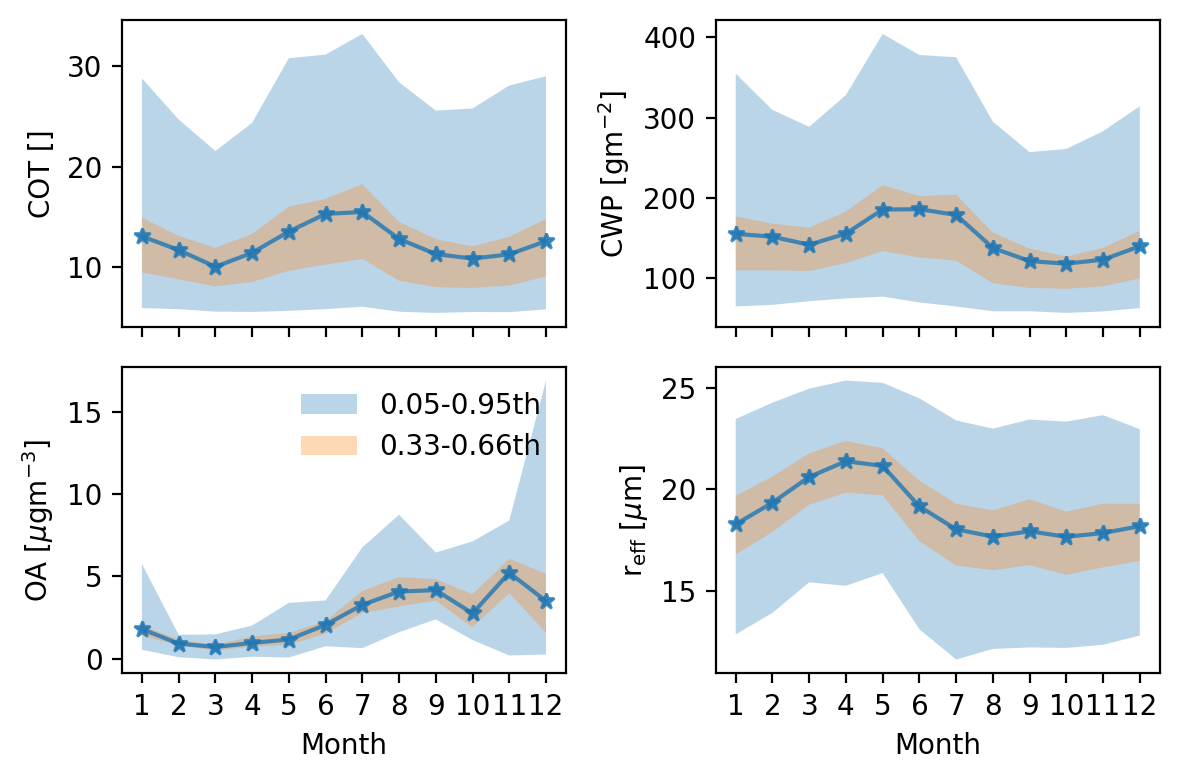

In [15]:
_df = ds_smr_sat.sel(time=slice('2014-01-01','2018-01-01')).to_dataframe()

  #  v_x = 'COT'
fig, axs = plt.subplots(2,2, dpi=200, sharex=True)
    

    
_ds_d = _df.copy().to_xarray()
_ds_d['time'] = pd.to_datetime(_ds_d['time'])

_ds_d['month'] = _ds_d['time.month']

for v_x, ax in zip(['COT','CWP (g m^-2)', 'OA (microgram m^-3)','CER (micrometer)'], axs.flatten()):
        print(v_x)
        #st_dev = _ds_d[v_x].mean(['LAT','LON']).groupby(_ds_d['month']).std()
        #_dfmq = _ds_d[v_x].mean(['LAT','LON']).groupby(_ds_d['month']).quantile([0.05,.33,.5, .66, .95])   
        _dfmq = _ds_d.to_dataframe().reset_index().groupby('month').quantile([0.05,.33,.5, .66, .95]).to_xarray().rename({'level_1':'quantile'})[v_x]
        mean = _ds_d[v_x].mean(['LAT','LON']).groupby(_ds_d['month']).median()
        ax.fill_between(_dfmq.month, _dfmq.sel(quantile=0.05), _dfmq.sel(quantile=0.95),  alpha=.3, label='0.05-0.95th')
        ax.fill_between(_dfmq.month, _dfmq.sel(quantile=0.33), _dfmq.sel(quantile=0.66),  alpha=.3, label= '0.33-0.66th')
        mean.plot(ax = ax, alpha=0.8, marker='*') 
        ax.set_ylabel(dic_nice_ylabel[v_x])
fig.tight_layout()
axs[-1,0].legend(frameon=False)#bbox_to_anchor=(1,1,))
ax.set_xticks(list(range(1,13)))
for ax in axs.flatten():
    ax.set_xlabel('')
    
for ax in axs[-1,:]:
    ax.set_xlabel('Month')
    
fig.tight_layout()
fn = make_fn('annual_distribution', 'props','percentiles', distplot=True)
print(fn)
#fig.savefig(fn)
plt.show()

In [16]:
ds_smr_sat['is_JA'] = ds_smr_sat['time.month'].isin(season2month[season])

In [17]:
ds_smr_sat_JA = ds_smr_sat.where(ds_smr_sat['is_JA'], drop=True)

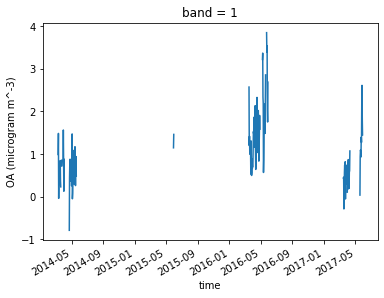

In [18]:
ds_smr_sat_JA['OA (microgram m^-3)'].plot()

In [19]:
ds_smr_sat_JA['OA (microgram m^-3)'].quantile([.333333,.666666])

<xarray.DataArray 'OA (microgram m^-3)' (quantile: 2)>
array([0.67705491, 1.25726987])
Coordinates:
  * quantile  (quantile) float64 0.3333 0.6667

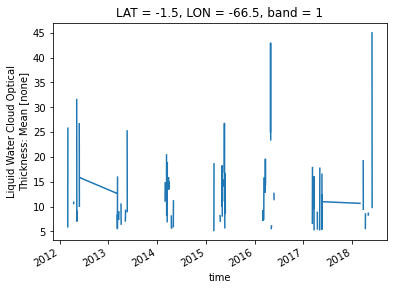

In [20]:
ds_smr_sat_JA['COT'].isel(LAT=0,LON=0).plot()

In [21]:
varsl = ['OA (microgram m^-3)', 'CWP (g m^-2)',
       'CER (micrometer)', 'COT',]

In [22]:
ds_smr_sat_JA['OA (microgram m^-3)'],_ =xr.broadcast(ds_smr_sat_JA['OA (microgram m^-3)'],ds_smr_sat_JA['COT'])

In [23]:
ds_smr_sat_JA[varsl]

<xarray.Dataset>
Dimensions:              (time: 644, LAT: 7, LON: 15)
Coordinates:
  * time                 (time) datetime64[ns] 2012-03-01 ... 2018-05-31
  * LAT                  (LAT) float64 -1.5 -2.5 -3.5 -4.5 -5.5 -6.5 -7.5
  * LON                  (LON) float64 -66.5 -65.5 -64.5 ... -54.5 -53.5 -52.5
    band                 int64 1
Data variables:
    OA (microgram m^-3)  (time, LAT, LON) float64 nan nan nan ... nan nan nan
    CWP (g m^-2)         (time, LAT, LON) float32 nan 277.0 nan ... 67.0 nan nan
    CER (micrometer)     (time, LAT, LON) float32 nan 22.87 nan ... nan nan
    COT                  (time, LAT, LON) float32 nan 18.43 nan ... nan nan

In [24]:
ds_smr_sat_JAs = ds_smr_sat_JA[varsl]#.rename({'x':'LON','y':'LAT'})#.isel(band=0)

## Drop pixels with few obs:

In [25]:
_df = ds_smr_sat_JAs.to_dataframe().drop('band', axis=1)

df_smr_sat_JAs = _df.dropna()

In [26]:
df_smr_sat_JAs#.dropna()

OA (microgram m^-3)  CWP (g m^-2)  CER (micrometer)  \
time       LAT  LON                                                          
2014-03-10 -1.5 -64.5              0.99000          62.0         18.480000   
                -59.5              0.99000          87.0         23.109999   
                -58.5              0.99000          84.0         20.480000   
                -57.5              0.99000         104.0         20.930000   
                -56.5              0.99000         115.0         19.070000   
...                                    ...           ...               ...   
2017-05-30 -7.5 -56.5              1.45007         219.0         19.920000   
                -55.5              1.45007         249.0         20.299999   
                -54.5              1.45007         305.0         21.049999   
                -53.5              1.45007         323.0         19.820000   
                -52.5              1.45007         338.0         22.389999   

                             COT  
time       LAT  LON               
2014-03-10 -1.5 -64.5   5.170000  
                -59.5   5.790000  
                -58.5   6.130000  
                -57.5   7.830000  
                -56.5   9.080000  
...                          ...  
2017-05-30 -7.5 -56.5  16.190001  
                -55.5  17.389999  
                -54.5  23.379999  
                -53.5  25.309999  
                -52.5  24.309999  

[5236 rows x 4 columns]

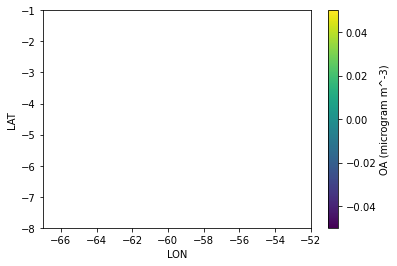

In [27]:
_df = df_smr_sat_JAs.reset_index()

da_cnt= _df.groupby([_df['LAT'],_df['LON']]).count().to_xarray()['OA (microgram m^-3)']#.plot()
da_cnt.where(da_cnt>100).plot()
da_drop_pixels = ~da_cnt.where(da_cnt>2).notnull()

In [28]:
#da_drop_pixels = ~da_cnt.notnull().rename({'lat':'LAT','lon':'LON'})

In [29]:
vl = ['FSNT','FLNT','FSNT_DRF','FLNT_DRF','FSNTCDRF','FLNTCDRF','FLNS','FSNS','FLNSC','FSNSC','FSDSCDRF','FSDS_DRF','FSUTADRF','FLUTC','FSUS_DRF','FLUS','CLOUD','FCTL','FCTI','NUCLRATE','FORMRATE','GRH2SO4','GRSOA','GR','COAGNUCL','H2SO4','SOA_LV','PS','LANDFRAC','COAGNUCL','FORMRATE','NUCLRATE','SOA_LV','H2SO4','SOA_NA','SO4_NA','NNAT_0','NCONC01','NCONC02','NCONC03','NCONC04','NCONC05','NCONC06','NCONC07','NCONC08','NCONC09','NCONC10','NCONC11','NCONC12','NCONC13','NCONC14','SIGMA01','SIGMA02','SIGMA03','SIGMA04','SIGMA05','SIGMA06','SIGMA07','SIGMA08','SIGMA09','SIGMA10','SIGMA11','SIGMA12','SIGMA13','SIGMA14','NMR01','NMR02','NMR03','NMR04','NMR05','NMR06','NMR07','NMR08','NMR09','NMR10','NMR11','NMR12','NMR13','NMR14','FSNS','FSDS_DRF','GR','GRH2SO4','GRSOA','CCN1','CCN2','CCN3','CCN4','CCN5','CCN6','CCN7','CCN_B','TGCLDCWP','cb_H2SO4','cb_SOA_LV','cb_SOA_NA','cb_SO4_NA','CLDTOT','CDNUMC','SO2','isoprene','monoterp','SOA_SV','OH_vmr','AOD_VIS','CAODVIS','CLDFREE','CDOD550','CDOD440','CDOD870','AEROD_v','CABS550','CABS550A','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','SOA_SEC01','SOA_SEC02','SOA_SEC03','SOA_SEC04','SOA_SEC05','SO4_SEC01','SO4_SEC02','SO4_SEC03','SO4_SEC04','SO4_SEC05','nrSOA_SEC01','nrSOA_SEC02','nrSOA_SEC03','nrSOA_SEC04','nrSOA_SEC05','nrSO4_SEC01','nrSO4_SEC02','nrSO4_SEC03','nrSO4_SEC04','nrSO4_SEC05','cb_SOA_SEC01','cb_SOA_SEC02','cb_SOA_SEC03','cb_SOA_SEC04','cb_SOA_SEC05','cb_SO4_SEC01','cb_SO4_SEC02','cb_SO4_SEC03','cb_SO4_SEC04','cb_SO4_SEC05']
vl.sort()
print(len(vl))
print(len(list(set(vl))))

163
133


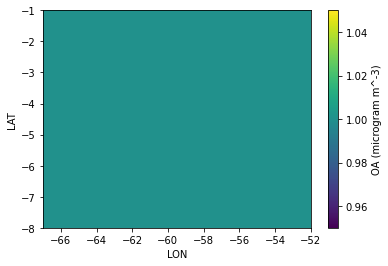

In [30]:
(~da_drop_pixels).plot()

In [31]:
ds_smr_sat_JAs = ds_smr_sat_JAs.where(~da_drop_pixels)

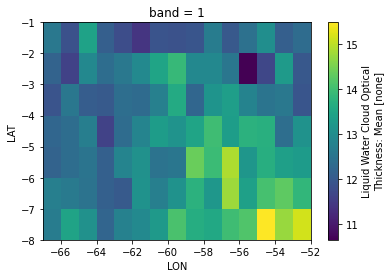

In [32]:
ds_smr_sat_JAs['COT'].mean('time').plot()

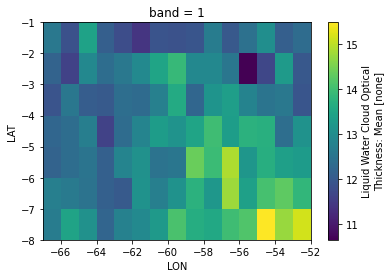

In [33]:
ds_smr_sat_JAs['COT'].mean('time').plot()

(array([ 105.,  840., 3780., 4410., 2835., 1260., 1365.,  420.,  210.,
         315.]),
 array([-0.79    , -0.325962,  0.138076,  0.602114,  1.066152,  1.53019 ,
         1.994228,  2.458266,  2.922304,  3.386342,  3.85038 ]),
 <BarContainer object of 10 artists>)

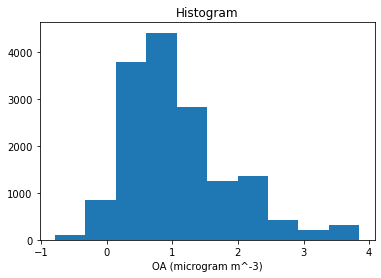

In [34]:
ds_smr_sat_JAs['OA (microgram m^-3)'].plot()
#['Org']

In [35]:
dic_OA_percentiles = dict()

In [36]:
_df = ds_smr_sat_JAs.drop('band').to_dataframe().reset_index().rename({'LAT':'lat','LON':'lon'},axis=1)#.dropna()#()

df_hyy_1 = _df.sort_values(['lat','lon']).set_index(['time','lat','lon'])

In [37]:
df_hyy_1

,,,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT
time,lat,lon,,,,
2012-03-01,-7.5,-66.5,NaN,211.0,22.230000,14.690000
2012-03-02,-7.5,-66.5,NaN,NaN,NaN,NaN
2012-03-03,-7.5,-66.5,NaN,NaN,NaN,NaN
2012-03-04,-7.5,-66.5,NaN,NaN,NaN,NaN
2012-03-05,-7.5,-66.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2018-05-27,-1.5,-52.5,NaN,NaN,NaN,NaN
2018-05-28,-1.5,-52.5,NaN,NaN,NaN,NaN
2018-05-29,-1.5,-52.5,NaN,83.0,17.299999,7.560000


df_smr_sat_JAsad model data:

## Load model data

In [38]:
model_name_noresm = 'NorESM'
model_name_echam  = 'ECHAM-SALSA' 
model_name_ec_earth  = 'EC-Earth' 
model_name_ukesm  = 'UKESM'

models =[model_name_noresm,model_name_echam,model_name_ec_earth,model_name_ukesm]

### Settings

In [39]:
def lon_sh(l):
    return ((l+180)%360-180) 

def lon_sh360(l):
    return ((l)%360)

In [40]:
models

['NorESM', 'ECHAM-SALSA', 'EC-Earth', 'UKESM']

In [41]:
l=-10
((l)%360)

350

In [42]:
#lat_lims = [60, 66]
#lon_lims = [22,30]
lon_lims = [293.,308.]
#lon_lims =[lon_sh(l) for l in lon_lims]
lat_lims = [-8.,-1.]

In [43]:
#lat_lims = [60, 66]
#lon_lims = [22,30]
lon_lims = [293.,308.]
#lon_lims =[lon_sh(l) for l in lon_lims]
lat_lims = [-8.,-1.]

### NorESM

In [44]:


lat_smr = -2.150
lon_smr = 360-59.009
model_lev_i=-1

temperature = 273.15  # K


str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'293.0-308.0_-8.0--1.0'

In [45]:
from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'

In [46]:
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'
model_name_noresm = 'NorESM'



#### Input files created in [03-01-01-create_file_ATTO.ipynb](03-01-01-create_file_ATTO.ipynb)

#### Input files

In [47]:
input_path_noresm = path_extract_latlon_outdata / model_name_noresm / case_name_noresm 

In [48]:
fn_noresm_csv = input_path_noresm / f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_{str_coordlims}_lev1_finalALL_year.csv'

In [49]:

cases_noresm = [case_name_noresm]

### ECHAM-SALSA

In [50]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res='locations'
model_name='ECHAM-SALSA'

#### Define some strings for files

In [51]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [52]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam 

In [53]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [54]:
cases_echam = [case_name_echam]

### EC-Earth

In [55]:

case_name = 'ECE3_output_Sara'
case_name_ec_earth = 'ECE3_output_Sara'
time_res = 'hour'
space_res='locations'
model_name='EC-Earth'
model_name_ec_earth ='EC-Earth'

#### Define some strings for files

In [56]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [57]:
input_path_ec_earth = path_extract_latlon_outdata / model_name_ec_earth/ case_name_ec_earth

In [58]:
fn_final_ec_earth = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ec_earth_csv = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [59]:
fn_final_ec_earth_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv')

In [60]:
cases_ec_earth = [case_name_ec_earth]

### UKESM

In [61]:

case_name = 'AEROCOMTRAJ'
case_name_ukesm = 'AEROCOMTRAJ'
time_res = 'hour'
space_res='locations'
model_name='UKESM'
model_name_ukesm ='UKESM'

#### Define some strings for files

In [62]:
str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')

#### Input files:

In [63]:
input_path_ukesm = path_extract_latlon_outdata / model_name_ukesm/ case_name_ukesm

In [64]:
fn_final_ukesm = input_path_ukesm / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ukesm_csv = input_path_ukesm / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}ALL_year.csv'

In [65]:
fn_final_ukesm_csv

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/UKESM/AEROCOMTRAJ/AEROCOMTRAJ_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv')

In [66]:
cases_ukesm = [case_name_ukesm]

### Read in model data

In [67]:
df_mod_noresm = pd.read_csv(fn_noresm_csv, index_col=[0,1,2],parse_dates=[0] )
df_mod_noresm['month'] =df_mod_noresm.index.get_level_values(0).month
df_mod_echam = pd.read_csv(fn_final_echam_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_echam['month'] =df_mod_echam.index.get_level_values(0).month
df_mod_ec_earth = pd.read_csv(fn_final_ec_earth_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_ec_earth['month'] =df_mod_ec_earth.index.get_level_values(0).month

df_mod_ukesm = pd.read_csv(fn_final_ukesm_csv, index_col=[0,1,2], parse_dates=[0] )
df_mod_ukesm['month'] =df_mod_ukesm.index.get_level_values(0).month

In [68]:
df_mod_ukesm.to_xarray()

<xarray.Dataset>
Dimensions:       (time: 2589, lat: 5, lon: 8)
Coordinates:
  * time          (time) datetime64[ns] 2011-12-31 2012-01-01 ... 2019-01-31
  * lat           (lat) float64 -6.875 -5.625 -4.375 -3.125 -1.875
  * lon           (lon) float64 293.4 295.3 297.2 299.1 300.9 302.8 304.7 306.6
Data variables: (12/33)
    station       (time, lat, lon) object 'ATTO' 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    r_eff         (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    liq_frac_cwp  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    CWP           (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    month         (time, lat, lon) int64 12 12 12 12 12 12 12 ... 1 1 1 1 1 1 1
    ismonth1      (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    ...            ...
    N50_STP       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    OA_STP        (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    N50-500_STP   (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    OA            (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    T_C           (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    year          (time, lat, lon) int64 2011 2011 2011 2011 ... 2019 2019 2019

## Pick out months:

In [69]:
df_mod_noresm = df_mod_noresm[df_mod_noresm['month'].isin(season2month[season])]
df_mod_echam = df_mod_echam[df_mod_echam['month'].isin(season2month[season])]
df_mod_ec_earth = df_mod_ec_earth[df_mod_ec_earth['month'].isin(season2month[season])]
df_mod_ukesm =df_mod_ukesm[df_mod_ukesm['month'].isin(season2month[season])] 

<AxesSubplot:ylabel='Frequency'>

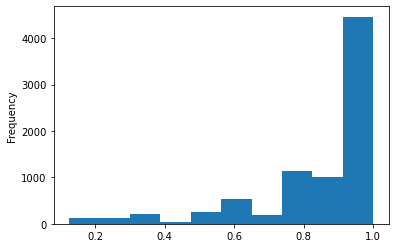

In [70]:
df_mod_echam['cl_time_ct'].plot.hist()

### Organize data in dictionary

In [71]:
dic_df=dict()
dic_df[model_name_echam] = df_mod_echam
dic_df[model_name_noresm] = df_mod_noresm
dic_df[model_name_ec_earth] = df_mod_ec_earth
dic_df[model_name_ukesm] = df_mod_ukesm

dic_df['Observations'] = df_hyy_1



### Not included anymore: *Scale CWP down for EC-Earth

_df = dic_df[model_name_ec_earth]
_df = _df.rename({'CWP':'CWP_orig'}, axis=1)
dic_df[model_name_ec_earth]  = _df

_df = dic_df[model_name_ec_earth]

if 'scaled' not in _df.columns:
    _df['CWP'] = _df['CWP_orig']*.7

    _df['scaled'] = True
    print('scaling CWP in EC-Earth')
dic_df[model_name_ec_earth]  = _df

## Check everythign is fine:

In [72]:
for mod in dic_df.keys():
    print(dic_df[mod].to_xarray())

<xarray.Dataset>
Dimensions:         (time: 644, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-03-01 2012-03-02 ... 2018-05-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/55)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    lcdnc_ct_cm3    (time, lat, lon) float64 nan nan nan 49.79 ... nan nan nan
    min_cl_tempair  (time, lat, lon) float64 nan nan nan 207.2 ... nan nan nan
    ceff_ct         (time, lat, lon) float64 nan nan nan 15.07 ... nan nan nan
    ceff            (time, lat, lon) float64 nan nan nan 0.0 ... 0.0 nan nan nan
    tempair_ct      (time, lat, lon) float64 nan nan nan 285.6 ... nan nan nan
    ...              ...
    mmrtrN50        (time, lat, lon) float64 1.069e+08 1.069e+08 ... 1.712e+08
    N50-500         (time, lat, lon) float64 137.1 137.1 137.1 ... 220.0 220.0
    N100-500        (time, l

## Rename variables:


<AxesSubplot:ylabel='Frequency'>

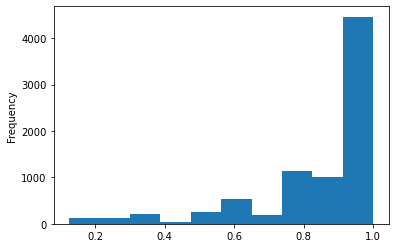

In [73]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

In [74]:
rn_dic_echam = {
    #'cwp'      : 'CWP',
   # 'cwp_incld'      : 'CWP',
   # 'cod'      : 'COT',
    #'ceff_ct'  : 'r_eff',
   # 'ceff_ct_incld'  : 'r_eff',
    'OA_STP':'OA',


}
rn_dic_ukesm = {
    #'cwp'      : 'CWP',
   # 'cwp_incld'      : 'CWP',
   # 'cod'      : 'COT',
    #'ceff_ct'  : 'r_eff',
   # 'ceff_ct_incld'  : 'r_eff',
    'OA_STP':'OA',


}
rn_dic_noresm = {
    'TGCLDLWP_incld'         : 'CWP',
    'TOT_CLD_VISTAU_s_incld': 'COT',
    'ACTREL_incld'     : 'r_eff',
    'OA_STP':'OA',
}
rn_dic_obs = {
    'CWP (g m^-2)'        : 'CWP',
    'CER (micrometer)'    : 'r_eff',
    'OA (microgram m^-3)' : 'OA',
    
}
rn_dic_ec_earth = {
    'OA_STP':'OA',
}

In [75]:
model2rndic = {
    model_name_noresm : rn_dic_noresm,
    model_name_ec_earth: rn_dic_ec_earth,
    model_name_echam:rn_dic_echam,
    model_name_ukesm:rn_dic_ukesm,
    'Observations': rn_dic_obs
}

#### Fix NorESM having OA as well as OA_STP

In [76]:
dic_df.keys()

dict_keys(['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'UKESM', 'Observations'])

In [77]:
models

['NorESM', 'ECHAM-SALSA', 'EC-Earth', 'UKESM']

In [78]:
for mod in models+ ['Observations']:
    _rn_dic = model2rndic[mod]
    print(mod)
    print(_rn_dic)
    if ('OA' in dic_df[mod].columns) & ('OA_STP' in dic_df[mod].columns):
        if ('OA_STP' in _rn_dic):
            if (_rn_dic['OA_STP']=='OA'):
                dic_df[mod] = dic_df[mod].drop(['OA'], axis=1)
                print('dropping OA in favor of OA_STP')
    dic_df[mod] = dic_df[mod].rename(_rn_dic, axis=1)

NorESM
{'TGCLDLWP_incld': 'CWP', 'TOT_CLD_VISTAU_s_incld': 'COT', 'ACTREL_incld': 'r_eff', 'OA_STP': 'OA'}
dropping OA in favor of OA_STP
ECHAM-SALSA
{'OA_STP': 'OA'}
EC-Earth
{'OA_STP': 'OA'}
UKESM
{'OA_STP': 'OA'}
dropping OA in favor of OA_STP
Observations
{'CWP (g m^-2)': 'CWP', 'CER (micrometer)': 'r_eff', 'OA (microgram m^-3)': 'OA'}


In [79]:
models

['NorESM', 'ECHAM-SALSA', 'EC-Earth', 'UKESM']

In [80]:
for mod in dic_df.keys():
    print(mod)
    print(dic_df[mod].to_xarray())

ECHAM-SALSA
<xarray.Dataset>
Dimensions:         (time: 644, lat: 3, lon: 8)
Coordinates:
  * time            (time) datetime64[ns] 2012-03-01 2012-03-02 ... 2018-05-31
  * lat             (lat) float64 -6.528 -4.663 -2.798
  * lon             (lon) float64 294.4 296.2 298.1 300.0 ... 303.8 305.6 307.5
Data variables: (12/55)
    station         (time, lat, lon) object 'ATTO' 'ATTO' ... 'ATTO' 'ATTO'
    lcdnc_ct_cm3    (time, lat, lon) float64 nan nan nan 49.79 ... nan nan nan
    min_cl_tempair  (time, lat, lon) float64 nan nan nan 207.2 ... nan nan nan
    ceff_ct         (time, lat, lon) float64 nan nan nan 15.07 ... nan nan nan
    ceff            (time, lat, lon) float64 nan nan nan 0.0 ... 0.0 nan nan nan
    tempair_ct      (time, lat, lon) float64 nan nan nan 285.6 ... nan nan nan
    ...              ...
    mmrtrN50        (time, lat, lon) float64 1.069e+08 1.069e+08 ... 1.712e+08
    N50-500         (time, lat, lon) float64 137.1 137.1 137.1 ... 220.0 220.0
    N100-500    

<AxesSubplot:ylabel='Frequency'>

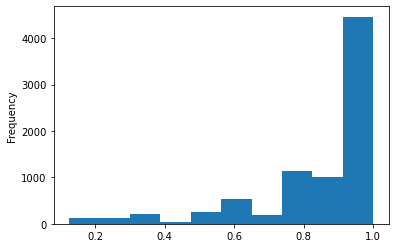

In [81]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

## Group by cloud water path 

#### Predefined bins

In [82]:
dic_bins = dict()
dic_bins[model_name_noresm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_echam] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_ec_earth] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_ukesm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins['Observations'] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])




## Mask data

### moved to pre-processing: NorESM: Masking if less than 5% liquid cloud top fraction and if liquid is less than 80% of the cloud top

### Bin model data:

CWP above 50. 

In [83]:
varl_categories = ['OA']#,'CLDFREE'

In [84]:
varlist_notna = ['OA','CWP','COT','r_eff']
varlist_notna_noCOT = set(varlist_notna)-set(['COT'])

In [85]:
n_bins = 7

for model_name in dic_df.keys():

    print(model_name)
    df_mod = dic_df[model_name].copy()
    ## drop nans:
    if model_name in ['UKESM','EC-Earth']:
        _vl = varlist_notna_noCOT
    else:
        _vl = varlist_notna
    df_mod = df_mod[df_mod[_vl].replace([np.inf, -np.inf], np.nan).notna().all(axis=1)]


    for v in varl_categories:
        q34 = df_mod[v].quantile(.3333333)
        print(q34)

        q66 = df_mod[v].quantile(.6666666)
        print(q66)
        if v=='OA':
            dic_OA_percentiles[model_name]=dict()
            dic_OA_percentiles[model_name]['33rd']=q34
            dic_OA_percentiles[model_name]['66th']=q66
            dic_OA_percentiles[model_name]['med_high']= df_mod[v][df_mod[v]>q66].median()
            dic_OA_percentiles[model_name]['med_low']= df_mod[v][df_mod[v]<q34].median()


        df_mod[f'{v}_low'] = df_mod[v]<q34
        df_mod[f'{v}_high']= df_mod[v]>q66
        mid_range = ( q34<df_mod[v]) & (df_mod[v]<q66)
        df_mod[f'{v}_mid_range'] = mid_range
        df_mod=df_mod.assign(**{f'{v}_category': pd.NA})
        df_mod.loc[df_mod[f'{v}_high'], f'{v}_category'] = f'{v} high'
        df_mod.loc[df_mod[f'{v}_low'], f'{v}_category'] = f'{v} low'

    bins = dic_bins[model_name]
    df_mod['CWP_cut']=pd.cut(df_mod['CWP'], bins=bins)#, labels=labels)

    
    df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)
    di = dict(df_mod.groupby('CWP_cut').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cutlm'] = df_mod['CWP_cut'].apply(lambda x:di[x])
    
    labels = np.arange(n_bins)
    # bins from 5th to 95th percentile
    qants = df_mod['CWP'].quantile([.0,.95])
    bins2 = pd.interval_range(qants.iloc[0], qants.iloc[1], periods=n_bins)
    bins2.values[-1] = pd.Interval(bins2[-1].left,np.inf)
    bins2.values[0] = pd.Interval(0,bins2[0].right)
 
    df_mod['CWP_cut2']=pd.cut(df_mod['CWP'], bins=bins2, labels=labels)
    di_per_lab = {bins2[i]:labels[i] for i in range(len(labels))}

    df_mod['CWP_cut2l'] = df_mod['CWP_cut2'].apply(lambda x:di_per_lab[x])
    # median label: 
    di = dict(df_mod.groupby('CWP_cut2').median()['CWP'])
    for k in di.keys():
        di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lm'] = df_mod['CWP_cut2'].apply(lambda x:di[x])
    
    #di = dict(df_mod.groupby('CWP_cut2').unique().mid)
    #for k in di.keys():
    #    di[k] = int(np.round(di[k]))
    df_mod['CWP_cut2lmid'] = df_mod['CWP_cut2'].apply(lambda x:np.round(x.mid))
    
    dic_df[model_name] = df_mod

ECHAM-SALSA
0.6018700800000001
1.43606115
NorESM
4.403393275443735
7.016417824914315
EC-Earth


/tmp/ipykernel_2625936/4114429425.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_mod = df_mod[df_mod[_vl].replace([np.inf, -np.inf], np.nan).notna().all(axis=1)]
/tmp/ipykernel_2625936/4114429425.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod[f'{v}_low'] = df_mod[v]<q34
/tmp/ipykernel_2625936/4114429425.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod[f'{v}_high']= df_mod[v]>q66
/tmp/ipykernel_2625936/41144

2.190047575476826
2.806507021052883
UKESM
2.399490456739163
3.1670565202741217
Observations
0.7375
1.4725000000000001


/tmp/ipykernel_2625936/4114429425.py:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_mod = df_mod[df_mod[_vl].replace([np.inf, -np.inf], np.nan).notna().all(axis=1)]
/tmp/ipykernel_2625936/4114429425.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod[f'{v}_low'] = df_mod[v]<q34
/tmp/ipykernel_2625936/4114429425.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod[f'{v}_high']= df_mod[v]>q66
/tmp/ipykernel_2625936/41144

In [86]:
dic_df.keys()
ds_ec = dic_df['EC-Earth'].to_xarray()

In [87]:
a = dic_df['NorESM'].T.duplicated()

In [88]:
a.index

Index(['station', 'CLDTOT', 'FLNT', 'transmittance', 'FSNT', 'FLUTC',
       'FLNTCDRF', 'FSDSCDRF', 'TGCLDIWP', 'CLDFREE',
       ...
       'OA_high', 'OA_mid_range', 'OA_category', 'CWP_cut', 'CWP_cutl',
       'CWP_cutlm', 'CWP_cut2', 'CWP_cut2l', 'CWP_cut2lm', 'CWP_cut2lmid'],
      dtype='object', length=112)

In [89]:
ds_no = dic_df['NorESM'].to_xarray()

In [90]:
dic_df[model_name_ec_earth]['OA']

time        lat    lon   
2012-03-01  -7.37  305.86    1.469965
            -6.67  300.94    1.469965
                   303.05    1.469965
                   305.16    1.469965
            -5.26  300.94    1.469965
                               ...   
2018-05-31  -1.05  304.45    4.557500
                   305.16    4.557500
                   306.56    4.557500
                   307.27    4.557500
                   307.97    4.557500
Name: OA, Length: 42109, dtype: float64

In [91]:
OA_percentile_df = pd.DataFrame(dic_OA_percentiles).T
OA_percentile_df['diff'] = OA_percentile_df['66th']- OA_percentile_df['33rd']

fn = make_fn('percentile_OA', 'OA','perc').with_suffix('.csv')
OA_percentile_df.to_csv(fn)

print(fn)
OA_percentile_df

Plots/cloud_props__percentile_OA_OA_perc_MAM.csv


,33rd,66th,med_high,med_low,diff
ECHAM-SALSA,0.601870,1.436061,2.448904,0.341160,0.834191
NorESM,4.403393,7.016418,9.759772,3.201999,2.613025
EC-Earth,2.190048,2.806507,3.221805,1.957331,0.616459
UKESM,2.399490,3.167057,3.904880,2.130121,0.767566
Observations,0.737500,1.472500,2.010715,0.496983,0.735000


<AxesSubplot:ylabel='Frequency'>

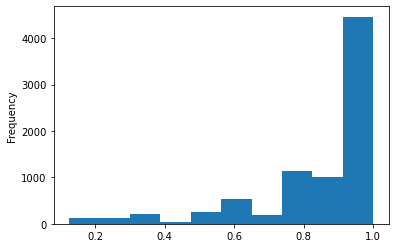

In [92]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

In [93]:
OA_percentile_df

,33rd,66th,med_high,med_low,diff
ECHAM-SALSA,0.601870,1.436061,2.448904,0.341160,0.834191
NorESM,4.403393,7.016418,9.759772,3.201999,2.613025
EC-Earth,2.190048,2.806507,3.221805,1.957331,0.616459
UKESM,2.399490,3.167057,3.904880,2.130121,0.767566
Observations,0.737500,1.472500,2.010715,0.496983,0.735000


## Quantile cut

In [94]:
for key in dic_df.keys():
    df_mod = dic_df[key]
    df_mod['CWP_qcut']=pd.qcut(df_mod['CWP'],6)# bins=bins, labels=labels)§
    df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)
    dic_df[key] = df_mod

In [95]:
pd.qcut(df_mod['CWP'][df_mod['CWP']<np.inf], 6)

time        lat   lon  
2014-03-11  -7.5  -66.5    (196.0, 263.0]
2014-03-15  -7.5  -66.5    (153.0, 196.0]
2014-03-19  -7.5  -66.5     (94.0, 122.0]
2014-03-25  -7.5  -66.5    (122.0, 153.0]
2014-04-01  -7.5  -66.5     (94.0, 122.0]
                                ...      
2017-05-20  -1.5  -52.5     (94.0, 122.0]
2017-05-21  -1.5  -52.5    (196.0, 263.0]
2017-05-25  -1.5  -52.5    (122.0, 153.0]
2017-05-26  -1.5  -52.5    (263.0, 863.0]
2017-05-28  -1.5  -52.5    (263.0, 863.0]
Name: CWP, Length: 5236, dtype: category
Categories (6, interval[float64, right]): [(49.999, 94.0] < (94.0, 122.0] < (122.0, 153.0] < (153.0, 196.0] < (196.0, 263.0] < (263.0, 863.0]]

# Distribution plots:

In [96]:
palette = 'Set2'

In [97]:
#cmap = cm.get_cmap(name=palette, )
cmap_list = ['#441FE0','#BBE01F'][::-1]#cmap(a) for a in np.linspace(0,1,8)]

palette_OA = cmap_list[0:2]

In [98]:
for key in dic_df.keys():
    _df = dic_df[key].copy()
    #_df = _df[_df[v_x]<x_cut]
    print(key)
    print(len(_df.dropna().reset_index()['time'].unique()))
    #_df.reset_index()['time'].unique().plot()

ECHAM-SALSA
424
NorESM
399
EC-Earth
405
UKESM
307
Observations
92


5236
Plots/dist_plot/cloud_props_distribution_mod_obs_COT_count_MAM.png


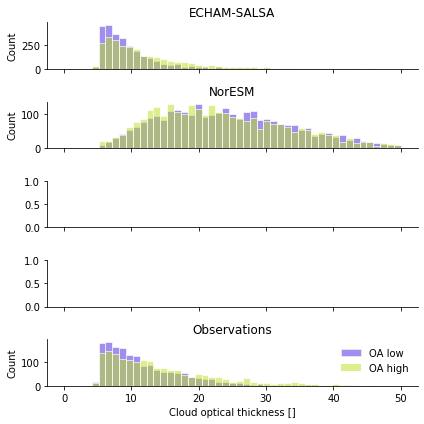

In [99]:
fig, axs = plt.subplots(5,1, sharex=True, figsize =[6,6])
v_x = 'COT'
x_cut = 100
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]
_bins = np.linspace(0,50)
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    if key in ['EC-Earth','UKESM']:
        continue
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins=_bins,
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud optical thickness []')
#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [100]:
_df = dic_df['UKESM'].copy()
_df.columns

Index(['station', 'r_eff', 'liq_frac_cwp', 'CWP', 'month', 'ismonth1',
       'ismonth2', 'ismonth3', 'ismonth4', 'ismonth5', 'ismonth6', 'ismonth7',
       'ismonth8', 'ismonth9', 'ismonth10', 'ismonth11', 'ismonth12', 'isJuly',
       'isAug', 'isJA', 'isSummer', 'model_level', 'N100_STP', 'N100-500_STP',
       'N200_STP', 'N200-500_STP', 'N500_STP', 'N50_STP', 'OA', 'N50-500_STP',
       'T_C', 'year', 'OA_low', 'OA_high', 'OA_mid_range', 'OA_category',
       'CWP_cut', 'CWP_cutl', 'CWP_cutlm', 'CWP_cut2', 'CWP_cut2l',
       'CWP_cut2lm', 'CWP_cut2lmid', 'CWP_qcut', 'CWP_qcutl'],
      dtype='object')

5235
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_MAM.png


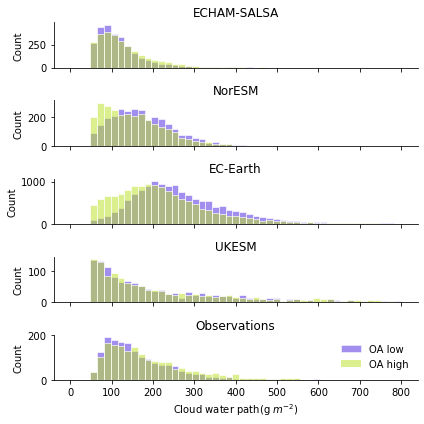

In [101]:
fig, axs = plt.subplots(5,1, sharex=True, figsize =[6,6])
_bins = np.linspace(0,800)
v_x = 'CWP'
x_cut = 800
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins = _bins,
    )
    if (key=='EC-Earth') and ('scaled' in _df.columns):
        title = f'{key}$\cdot$0.7'
    else:
        title = key
#plt.ylim([0,250])
    ax.set_title(title)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



5227
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_MAM.png


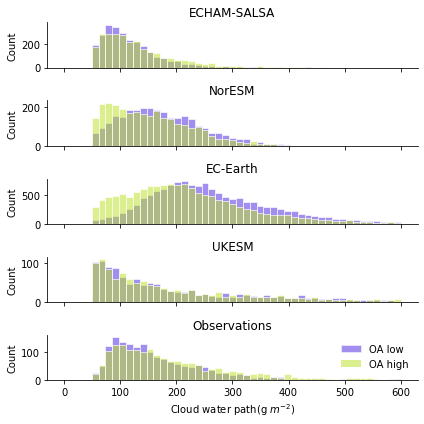

In [102]:
fig, axs = plt.subplots(5,1, sharex=True, figsize =[6,6])
_bins = np.linspace(0,600)
v_x = 'CWP'
x_cut = 600
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax,
        bins = _bins,
    )
    if (key=='EC-Earth') and ('scaled' in _df.columns):
        title = f'{key}$\cdot$0.7'
    else:
        title = key
#plt.ylim([0,250])
    ax.set_title(title)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



1655
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_MAM.png


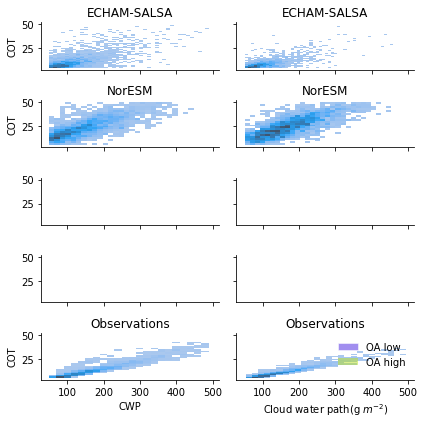

In [103]:
fig, axs = plt.subplots(5,2,  figsize =[6,6], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for i, key in enumerate(dic_df.keys()):
    if key in ['EC-Earth','UKESM']:

        continue
    axs_sub = axs[i,:]
    for hue_v, ax in zip(hue_order, axs_sub):
        _df = dic_df[key].copy()
        _df = _df[_df[v_x]<x_cut]
        _df = _df[_df[v_hue]==hue_v]
    
        sns.histplot(
            x=v_x,
            y=v_y, 
            data=_df,
            #hue=v_hue,
            #hue_order=hue_order,
#            palette=_palette,
            legend=False,
        #edgecolor='w',
        ax = ax
        )
        #plt.ylim([0,250])
        ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



1655
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_MAM.png


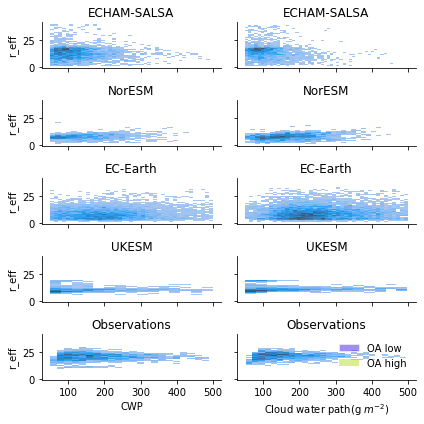

In [104]:
fig, axs = plt.subplots(5,2,  figsize =[6,6], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'r_eff'
x_cut = 500
y_cut = 40
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for i, key in enumerate(dic_df.keys()):
    #if key=='EC-Earth':
    #    continue
    axs_sub = axs[i,:]
    for hue_v, ax in zip(hue_order, axs_sub):
        _df = dic_df[key].copy()
        _df = _df[_df[v_x]<x_cut]
        _df = _df[_df[v_y]<y_cut]
        _df = _df[_df[v_hue]==hue_v]
    
        sns.histplot(
            x=v_x,
            y=v_y, 
            data=_df,
            #hue=v_hue,
            #hue_order=hue_order,
#            palette=_palette,
            legend=False,
        #edgecolor='w',
        ax = ax
        )
        #plt.ylim([0,250])
        ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [105]:
hue_v = 'OA high'

5169
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_MAM.png


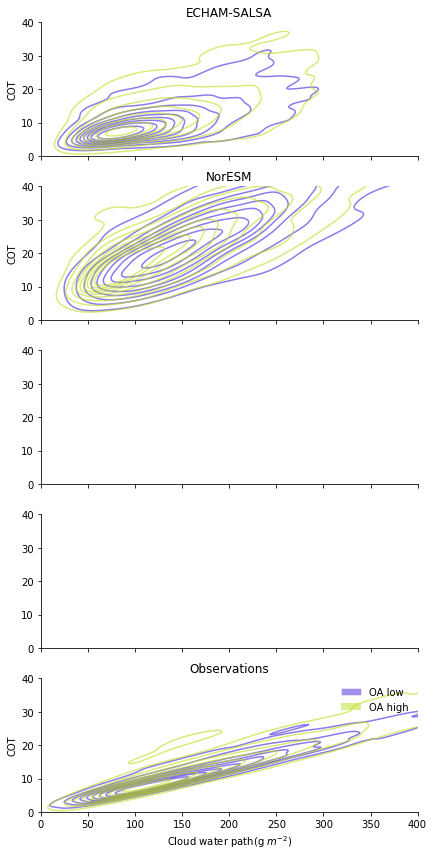

In [106]:
fig, axs = plt.subplots(5,1,  figsize =[6,12], sharex=True, sharey=True)

v_x = 'CWP'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    if key in ['EC-Earth','UKESM']:

        continue
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,400])
    ax.set_ylim([0,40])    

5236
Plots/dist_plot/cloud_props_distribution_mod_obs_r_eff_count_MAM.png


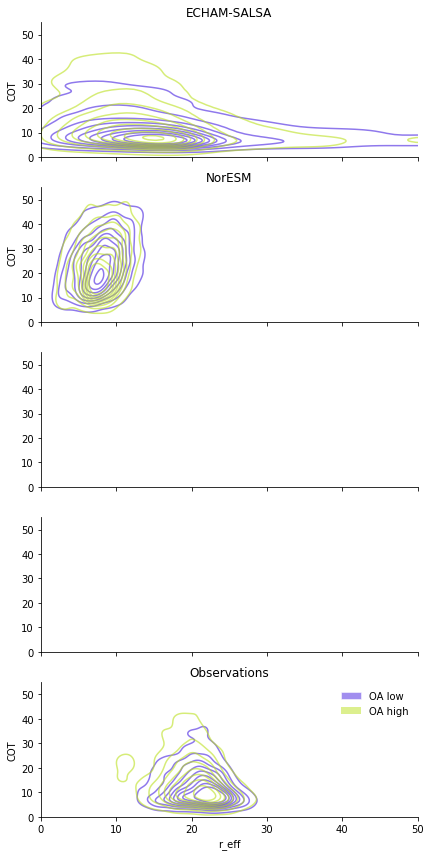

In [107]:
fig, axs = plt.subplots(5,1,  figsize =[6,12], sharex=True, sharey=True)

v_x = 'r_eff'
v_y = 'COT'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    if key in ['EC-Earth','UKESM']:
        continue
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel(v_x)
ax.set_ylabel(v_y)

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

#fig.savefig(fn, dpi=150)
fig.tight_layout()
#fig.savefig(fn, dpi=150)
#fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,50])
    ax.set_ylim([0,55])    

5169
Plots/dist_plot/cloud_props_distribution_mod_obs_CWP_count_MAM.png


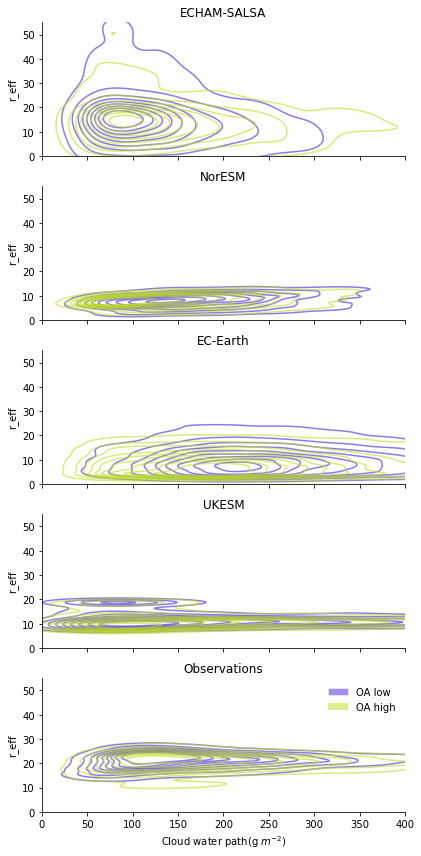

In [108]:
fig, axs = plt.subplots(5,1,  figsize =[6,12], sharex=True, sharey=True)

v_y = 'r_eff'
v_x = 'CWP'
x_cut = 500
v_hue = 'OA_category'
hue_order=['OA low', 'OA high']

_palette = palette_OA[::-1]#cmap_list[0:2]


for ax, key in zip(axs, dic_df.keys()):
    #for hue_v, ax in zip(hue_order, axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    #_df = _df[_df[v_hue]==hue_v]
    sns.kdeplot(
            x=v_x,
            y=v_y, 
            data=_df,
            hue=v_hue,
            hue_order=hue_order,
            palette=_palette,
        #alpha=0.5
            legend=False,
        alpha=.6,
        #edgecolor='w',
        ax = ax
    )
        #plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[0], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[1], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)

# fig.savefig(fn, dpi=150)
fig.tight_layout()
# fig.savefig(fn, dpi=150)
# fig.savefig(fn.with_suffix('.pdf'), dpi=150)

for ax in axs:
    ax.set_xlim([0,400])
    ax.set_ylim([0,55])    

<AxesSubplot:ylabel='Frequency'>

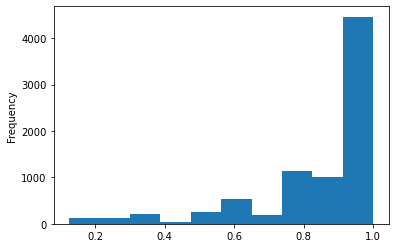

In [109]:
dic_df[model_name_echam]['cl_time_ct'].plot.hist()

In [110]:
s = dic_df[model_name_echam]['r_eff']#*dic_df[model_name_echam]['cl_time']
s = s[0<s]
len(s[s.notna()])

8117

In [111]:
len(dic_df['ECHAM-SALSA'])

8117

In [112]:
len(dic_df['NorESM'].dropna())

5678

8117
8557
42109
3711
5236
Plots/dist_plot/cloud_props_distribution_mod_obs_r_eff_count_MAM.png


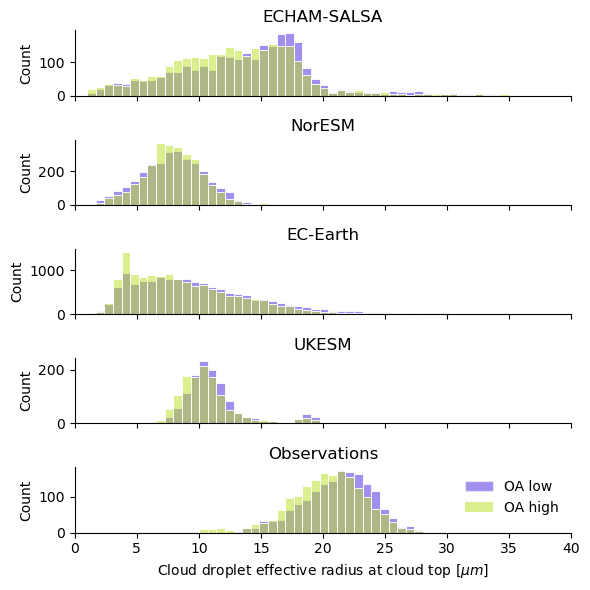

In [113]:
fig, axs = plt.subplots(5,1, sharex=True, figsize =[6,6], dpi=100)

v_x = 'r_eff'
x_cut = 700
_bins = np.linspace(1, 35)
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]
_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    _df = _df[_df[v_x]>0]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        bins = _bins,
        ax = ax
    )
    #plt.ylim([0,250])
    ax.set_title(key)#'Observations')
    print(len(_df))
    


custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud droplet effective radius at cloud top [$\mu m$]')

#plt.ylim([0,250])
sns.despine(fig)

for ax in axs: 
    ax.set_xlim([0,40])
fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()
fn = make_fn('mod_obs', v_x,'count',comment='distribution', distplot=True)
print(fn)
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)



In [114]:
ds_ech = dic_df['ECHAM-SALSA'].to_xarray()

In [115]:
ds_nor = dic_df['NorESM'].to_xarray()

# Calculate difference between high OA and low


In [116]:
from bs_fdbck_clean.util.plot.BSOA_plots import cdic_model

In [117]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [118]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

In [119]:
from sklearn.utils import resample

## Bootstrap resampling 

In [120]:
def bootstrap_subset(_df_low,_df_high, var='COT', category='CWP_cutlm', itts=10000):      
    


    cat_cats = list(_df_low[category][_df_low[category].notna()].unique())
    cat_cats.sort()

    df_sample_med = pd.DataFrame(columns=cat_cats, index = range(itts))

    df_sample_med

    for ca in cat_cats:
        _df_lc = _df_low[_df_low[category]==ca]
        _df_hc = _df_high[_df_high[category]==ca]
        print(f'length of {ca} is {len(_df_lc)} and {len(_df_hc)}')
        print(f'number of days is {len(_df_lc.reset_index().time.unique())} and {len(_df_hc.reset_index().time.unique())}')
        list_diff_meds = list()
        for it in range(itts):
            boot_l =resample(_df_lc[var])
            boot_h =resample(_df_hc[var])
    
            diff_median = boot_h.median()- boot_l.median()
            list_diff_meds.append(diff_median)
        print(len(list_diff_meds))
        df_sample_med[ca] = list_diff_meds
    
    return df_sample_med
    
def bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var='COT', category='CWP_cutlm', itts=10000):
    if quantiles is None:
        quantiles =[0.05, 0.5, 0.95]
    df_sample_med= bootstrap_subset(_df_low,_df_high, var=var, category=category, itts=itts)
    
    return df_sample_med.quantile(quantiles)
    
    
    #oob = [x for x in _df_low[var] if x not in boot]
    #print(resample(_df_low).median())
    #print(_df_low.median())
    
        

## Calculate CIs with bootstrap

In [121]:
hue_labs = ['OA low', 'OA high']
hue_var = 'OA_category'

itterations = 50000



x_var = 'CWP_cut2lm'
y_var1 = 'COT'
y_var2 = 'r_eff'



dic_median_CI = dict()
for ax, y_var in zip(axs,[y_var1, y_var2]):
    dic_median_CI[y_var] = dict()
    for key in dic_df.keys():
        print(key)
        if (key in ['EC-Earth', 'UKESM']) and (y_var=='COT'):
            continue
        _df = dic_df[key].copy()
    
        _df_lim =_df.copy() 
        notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
        _df_lim = _df_lim[notna]
        print('Total number of days:')
        print(len(_df_lim.reset_index()['time'].unique()))
        #_df_lim = _df_lim[_df_lim[y_var].notna()]
        #_df_lim = _df_lim[_df_lim[hue_var].notna()]
    
        _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
        _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        med_low = _df_low.groupby(x_var).median()
        med_high = _df_high.groupby(x_var).median()
        #std_low = _df_low.groupby(x_var).std()
        #std_high = _df_high.groupby(x_var).std()
        n_low = _df_low.groupby(x_var).count()['OA_category']
        n_high = _df_high.groupby(x_var).count()['OA_category']
        df_numb = pd.DataFrame()
        df_numb['n_low'] = n_low
        df_numb['n_high'] = n_high
        df_numb['n_str'] = df_numb['n_low'].astype(str) + '/' + df_numb['n_high'].astype(str) 
        
    
    
        diff_med = med_high-med_low
        
        df_sample_quant =bootstrap_return_quantiles(_df_low,_df_high, 
                               quantiles = None,
                               var=y_var, category=x_var, itts=itterations)
        #df_bs_samp_med = df_sample_quant.loc[0.5]
        dic_median_CI[y_var][key]=dict()
        dic_median_CI[y_var][key]['sample_median']=diff_med.copy()
        dic_median_CI[y_var][key]['bootstrap_quant']=df_sample_quant.copy()
        dic_median_CI[y_var][key]['number']=df_numb#['n_str']

ECHAM-SALSA
Total number of days:
424
length of 65 is 544 and 534
number of days is 181 and 210
50000
length of 89 is 752 and 613
number of days is 185 and 211
50000
length of 115 is 535 and 496
number of days is 180 and 202
50000
length of 140 is 365 and 359
number of days is 162 and 173
50000
length of 166 is 191 and 219
number of days is 114 and 120
50000
length of 193 is 128 and 161
number of days is 91 and 107
50000
length of 244 is 179 and 321
number of days is 101 and 147
50000
NorESM
Total number of days:
399
length of 70 is 279 and 582
number of days is 118 and 132
50000
length of 104 is 470 and 555
number of days is 158 and 160
50000
length of 139 is 565 and 481
number of days is 168 and 153
50000
length of 174 is 490 and 449
number of days is 160 and 145
50000
length of 209 is 428 and 324
number of days is 154 and 119
50000
length of 244 is 285 and 233
number of days is 126 and 99
50000
length of 300 is 321 and 217
number of days is 139 and 101
50000
EC-Earth
UKESM
Observati

In [122]:
v = 'COT'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', 'OA',v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)

    print((sa_med['COT']*sa_num['n_tot']).sum()/ sa_num['n_tot'].sum())

ECHAM-SALSA
1.1822170619140264
NorESM
1.108577173093855
Observations
0.7731318638676113


In [123]:
dic_median_CI['r_eff'].keys()

dict_keys(['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'UKESM', 'Observations'])

In [124]:
v = 'r_eff'
for source in dic_median_CI[v].keys():
    print(source)
    sa_med = dic_median_CI[v][source]['sample_median']

    sa_num = dic_median_CI[v][source]['number']

    sa_num['n_tot'] = sa_num['n_low'] + sa_num['n_high']
    _df_both = pd.concat([sa_med,sa_num], axis=1)
    
    fn = make_fn('sample_stats', 'OA',v, comment=source).with_suffix('.csv')
    _df_both.to_csv(fn)

    

ECHAM-SALSA
NorESM
EC-Earth
UKESM
Observations


In [125]:
dic_season_nicename = {
    'JFM':'Jan-Mar',
    'FMA':'Feb-Apr',
    'FMAM':'Feb-May',
    'JFMAM':'Jan-May',
    'MAM':'Mar-May',
    'JA':'July-Aug',
}

# Final plot: 

hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
Plots/rel_plot/cloud_props_r_eff_diff_median_OA_category_COT_CWP_cut2lm_MAM.png


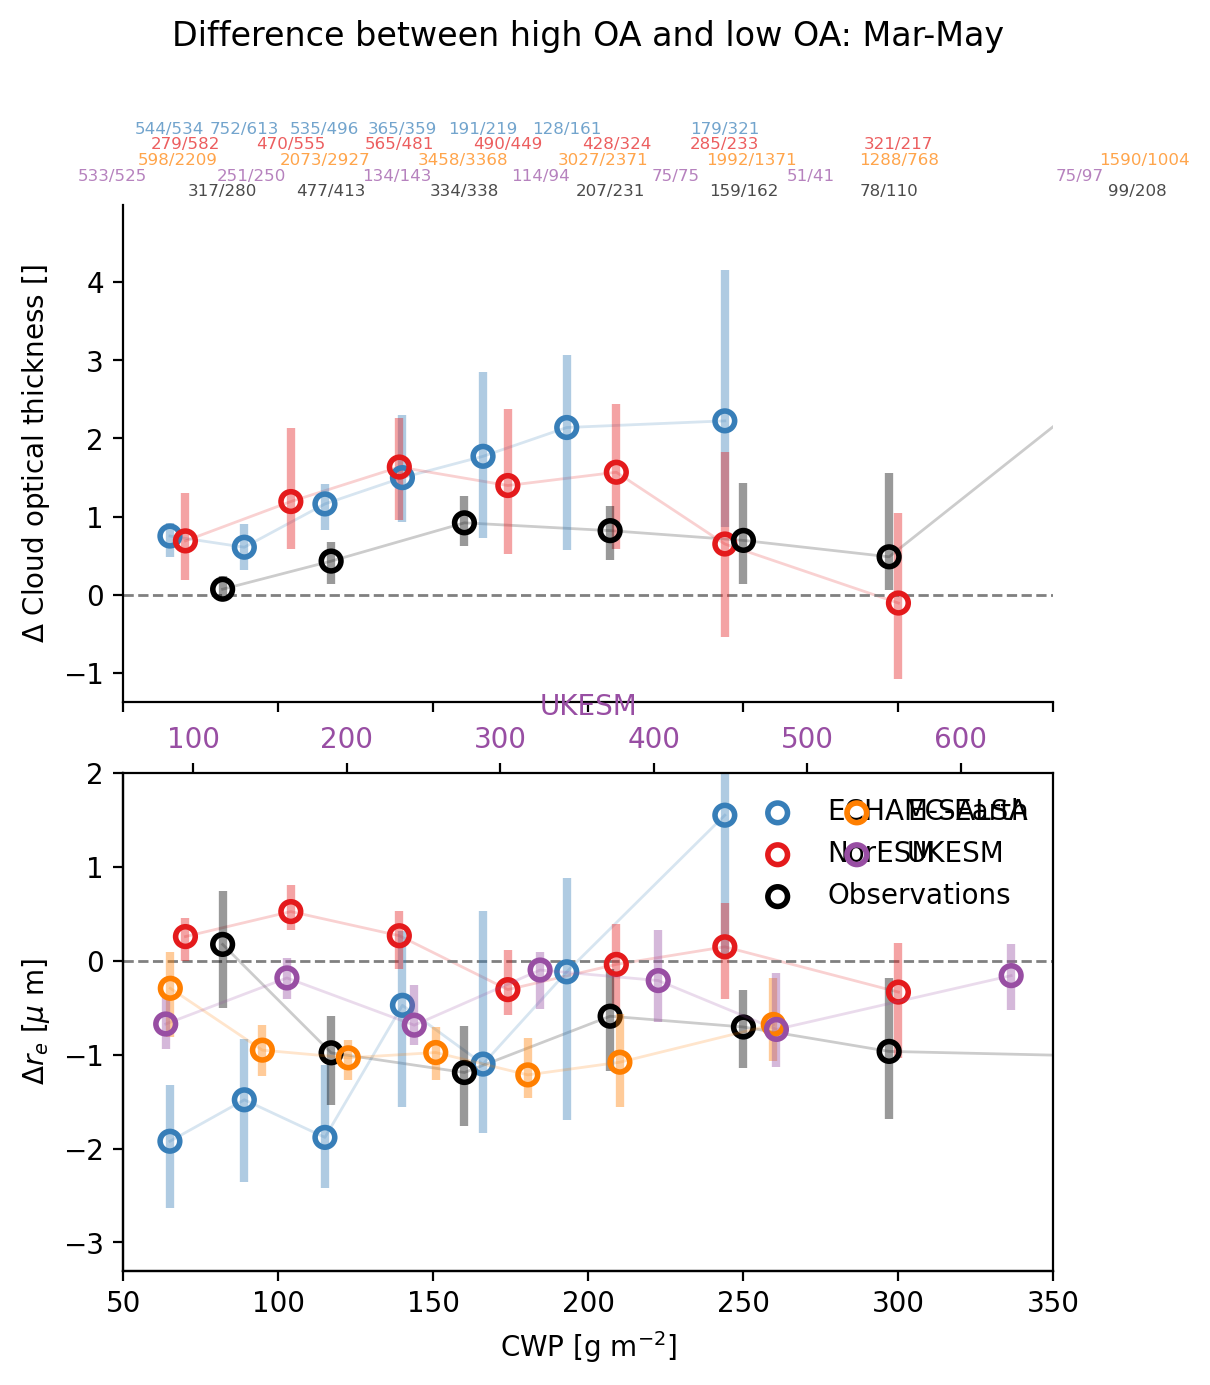

In [126]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
hue_lan_high= ['OA low', 'OA high']
hue_var = 'OA_category'

ylim2 =[-3.3,2]# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(3,1,figsize=figsize, sharey='row', sharex='col', dpi=200, gridspec_kw={'height_ratios': [1, 7, 7]})

ax_num =axs_all[0]
ax_num_ukesm =axs_all[0].twiny()
axs = axs_all[[1,2]]

x_var = 'CWP_cut2lm'

y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical thickness []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos = 0





for ax_use, y_var in zip(axs,[y_var1, y_var2]):
    if y_var !='COT':
        ax_use_twin = ax_use.twiny()

    
    for key in dic_df.keys():
        if (key in ['EC-Earth', 'UKESM']) and (y_var =='COT'):
            continue
        if key in ['UKESM','EC-Earth']:
            ax = ax_use_twin
            ax.set_xlabel('UKESM', color=cdic_model[key], fontsize=10)  # we already handled the x-label with ax1
            ax.tick_params(axis='x', labelcolor=cdic_model[key])

        else:
            ax = ax_use
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        label = key
        #if key=='EC-Earth':
        #    label = f'{key}, 0.5CWP'
        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=label,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 

        for xi in df_number.index:

            si = df_number.loc[xi]['n_str']
            if key in ['UKESM','EC-Earth']:
                xi = xi*((ax_use.get_xlim()[1]-ax_use.get_xlim()[0])/(ax.get_xlim()[1]-ax.get_xlim()[0]))
                print('hey')
                #ax_num_ukesm.text(xi, y_pos, si,
                #    c = cdic_model[key],
                #        fontsize=6,
                #    horizontalalignment='center',
                #        alpha=.7,
                #   )
            #else:
            ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.7,
                           )
        #            transform=ax.transAxes,)
        y_pos -=.22
        
ax_num.xaxis.set_visible(False)
ax_num_ukesm.xaxis.set_visible(False)
ax_num.yaxis.set_visible(False)
ax_num_ukesm.yaxis.set_visible(False)
sns.despine(ax=ax_num,right=True, left = True, bottom=True, top=True)
sns.despine(ax=ax_num_ukesm,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)
axs[1].set_xlim([50,350])

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False)
ax_use_twin.legend(frameon=False)

ax_num.set_title(f'Difference between high OA and low OA: {dic_season_nicename[season]}')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median', relplot=True)
print(fn)
#fig.savefig(fn, dpi=150)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

In [127]:
'/\n'.join(si.split('/'))

'99/\n208'

Plots/rel_plot/cloud_props_r_eff_diff_median_full_OA_category_COT_CWP_cut2lm_MAM.png


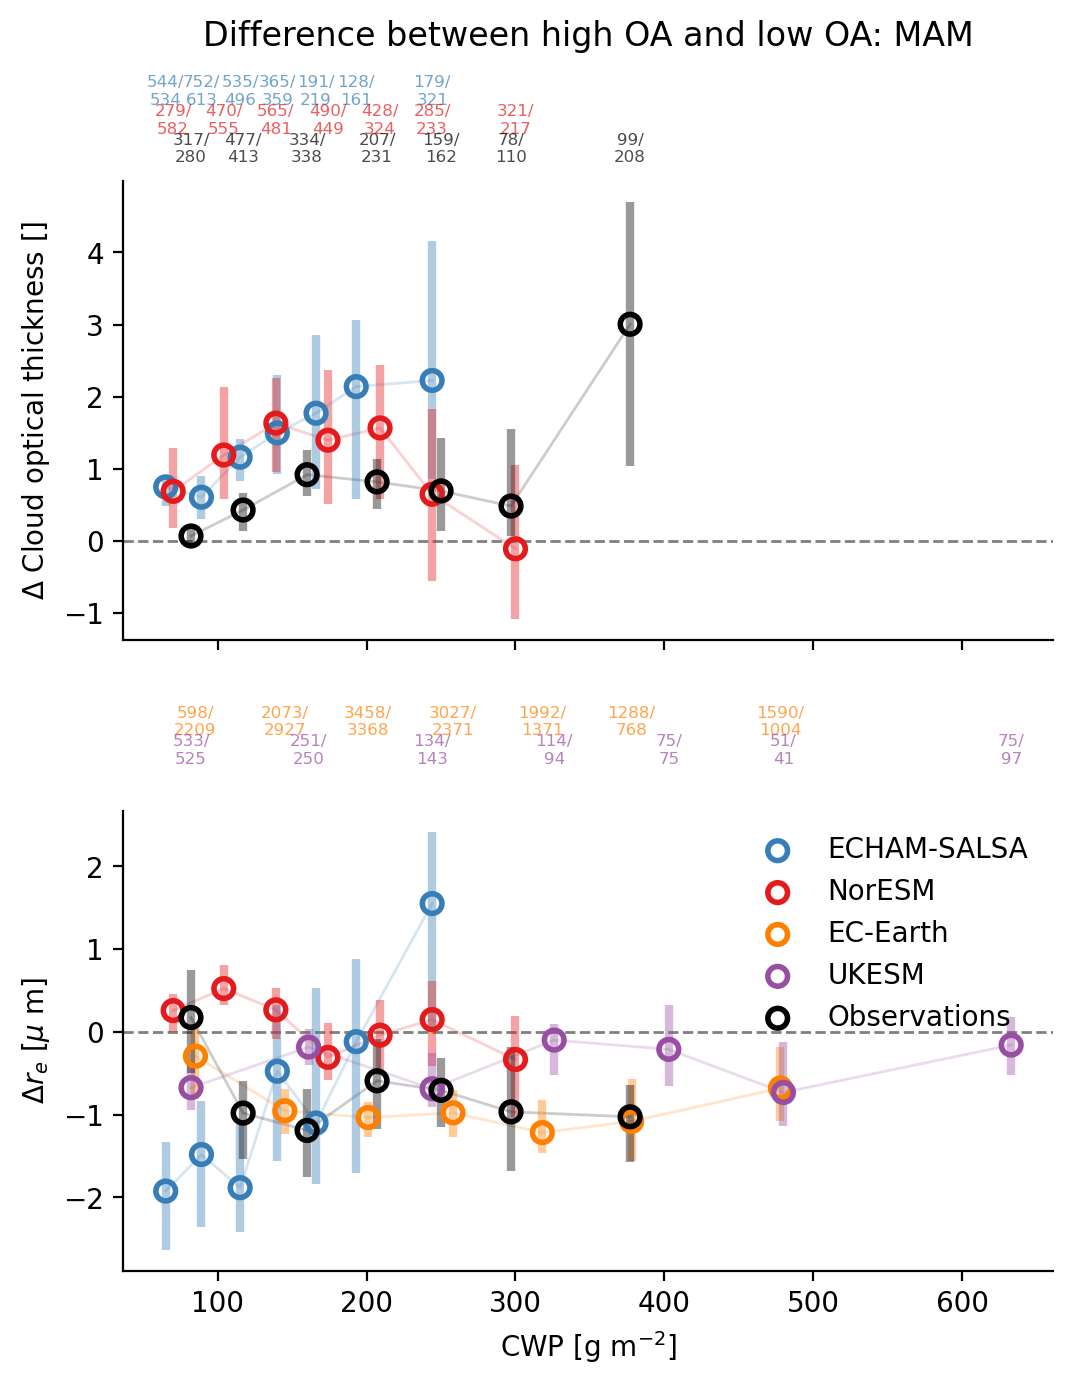

In [128]:
figsize = [6,8]
_palette = palette_OA_2
ylim = None#[0,25]
alpha_err=0.4
hue_lan_high= ['OA low', 'OA high']
hue_var = 'OA_category'

ylim2 =None# [-4,4]
markersize= 2

fig, axs_all = plt.subplots(4,1,figsize=figsize, sharey='row', sharex='col', dpi=200,
                            gridspec_kw={'height_ratios': [1, 7, 1,7]})

ax_num =axs_all[0]
ax_num2 = axs_all[2]
axs = axs_all[[1,3]]

x_var = 'CWP_cut2lm'

y_var1 = 'COT'
y_var2 = 'r_eff'

ylab1 = r'$\Delta $ Cloud optical thickness []'
ylab2 = r'$\Delta r_e$ [$\mu$ m]'
y_pos1 = .8
y_pos2 = .8

models_and_obs = list(dic_df.keys())
ax = axs[0]
for ax, y_var in zip(axs,[y_var1, y_var2]):
    
    
    for key in models_and_obs:
        if (key in ['EC-Earth', 'UKESM']) and (y_var =='COT'):
            continue
        diff_med = dic_median_CI[y_var][key]['sample_median']
        df_sample_quant = dic_median_CI[y_var][key]['bootstrap_quant']
        df_number = dic_median_CI[y_var][key]['number']

        df_bootstrap_med = df_sample_quant.loc[0.5]
        plt_med = diff_med[y_var]
        label = key
        #if key=='EC-Earth':
        #    label = f'{key}, 0.5CWP'
        ax.scatter(plt_med.index, plt_med, ec=cdic_model[key],lw=2, label=label,s=50,fc='none')
        ax.plot(plt_med.index, plt_med, c=cdic_model[key],lw=1, label='__nolegend__',zorder=-20,
               alpha=.2)
        #ax.scatter(df_bootstrap_med.index, df_bootstrap_med, c=cdic_model[key], label=key,s=200, marker='x')

        df_sample_quant_CI= df_sample_quant.drop(labels=0.5).T
        yerr = np.abs(df_sample_quant_CI.T - plt_med)
        
        ax.errorbar(plt_med.index, plt_med, yerr=yerr.values, 
                    #capsize=5,capthick=2,
                    c=cdic_model[key], linewidth=0, elinewidth=3, alpha=alpha_err,zorder=0)
        
        if y_var !=y_var2:
            continue
        df_number['n_str'] = df_number['n_low'].astype(str) + '/' + df_number['n_high'].astype(str) 
        #ax.text(df_numb.index, 
        if key in ['NorESM','ECHAM-SALSA', 'Observations']:
            _ax_num = ax_num
            y_pos1 -=.44
            y_pos = y_pos1
        else:
            _ax_num = ax_num2
            y_pos2 -=.44
            y_pos = y_pos2
        for xi in df_number.index:
            si = df_number.loc[xi]['n_str']
            si = '/\n'.join(si.split('/'))

            _ax_num.text(xi, y_pos, si,
                    c = cdic_model[key],
                        fontsize=6,
                    horizontalalignment='center',
                        alpha=.7,
                        zorder=1000000,
                   )
        #if key == models_and_obs[2]:
        #    y_pos = 0
        #else:
        y_pos -=.44
for _ax in [ax_num, ax_num2]:
    _ax.xaxis.set_visible(False)
    _ax.yaxis.set_visible(False)
    sns.despine(ax=_ax,right=True, left = True, bottom=True, top=True)
for ax in axs:
    ax.axhline(0, c='.5',zorder=-10,lw=1, linestyle='--')
    
axs[0].set_ylabel(ylab1)
axs[1].set_ylabel(ylab2)
axs[1].set_ylim(ylim2)

axs[1].set_xlabel('CWP [g m$^{-2}$]')

ax.legend(frameon=False)

ax_num.set_title(f'Difference between high OA and low OA: {season}')

#ax_num.set_ylim([0,1])

sns.despine(ax = axs[0])
sns.despine(ax = axs[1])
fn = make_fn(hue_var, y_var1,x_var,comment=f'{y_var2}_diff_median_full', relplot=True)
print(fn) 
#for ax in axs:
#    ax.set_xlim([50,450])

#fig.savefig(fn, dpi=150)
#fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Supplementary plots

In [129]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

In [130]:
order_keys = [model_name_noresm, model_name_echam, 'Observations']

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 27.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cutl_MAM.png


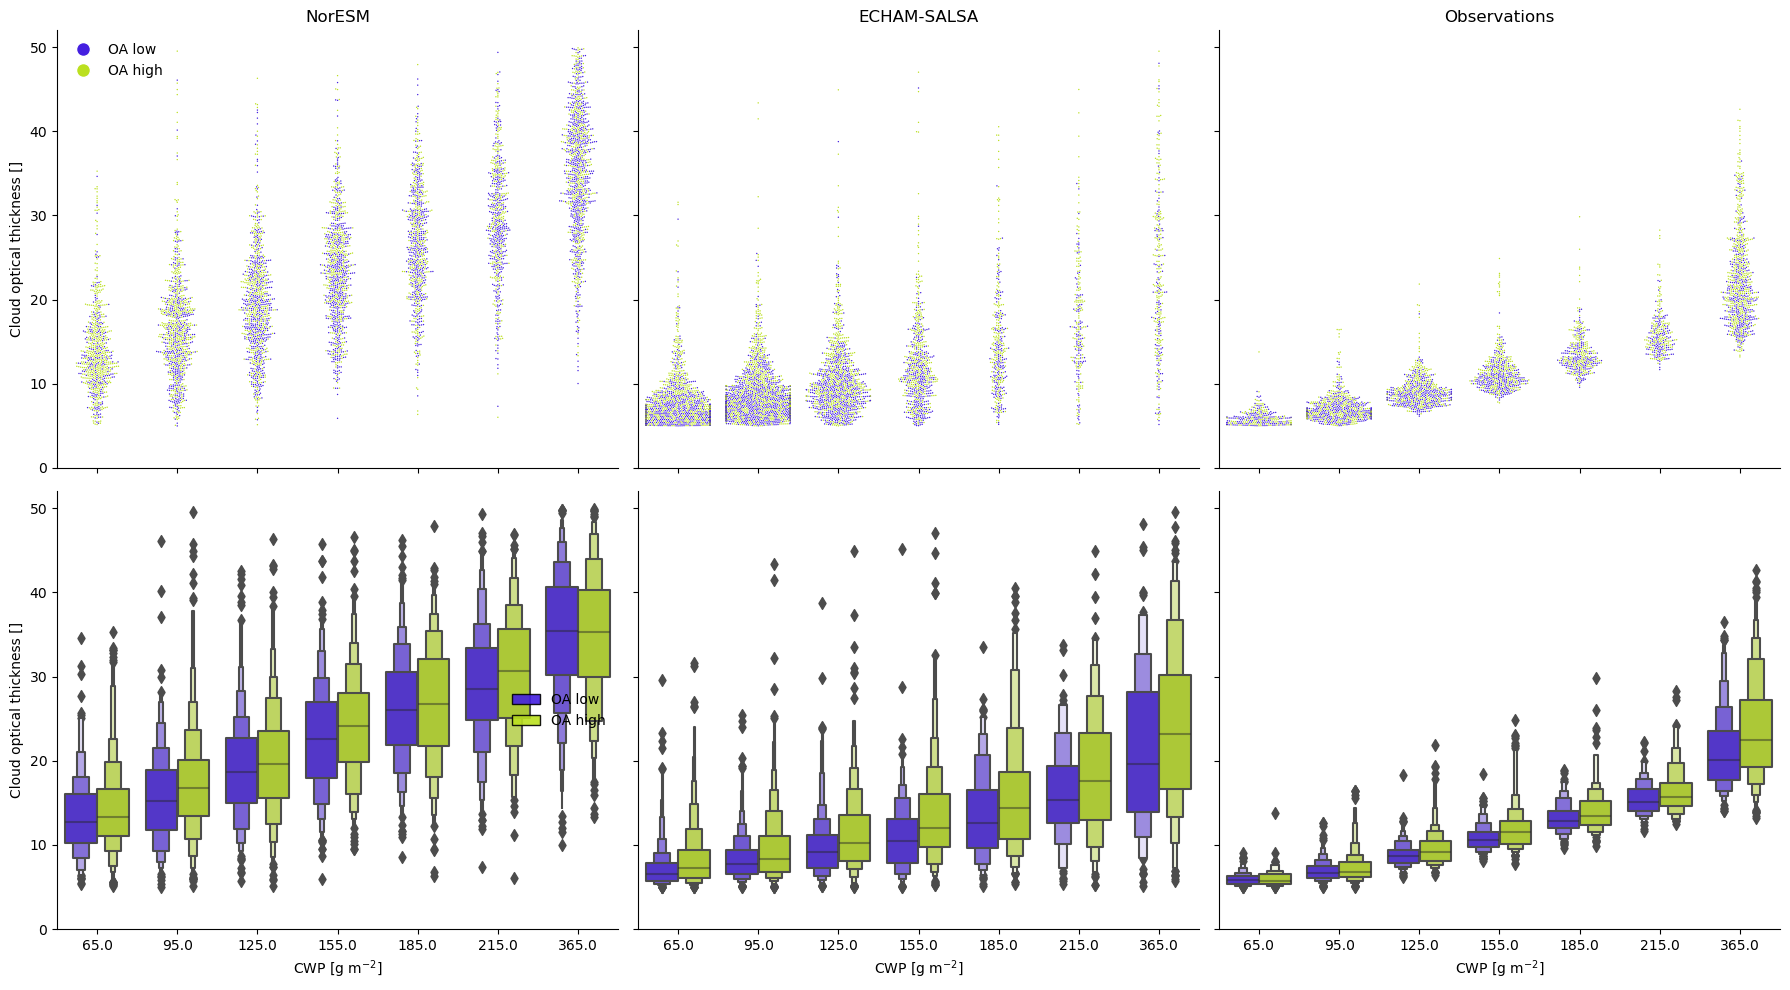

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_COT_CWP_cutl_MAM.png


In [131]:
x_var = 'CWP_cutl'
y_var = 'COT'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,52]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 1



for key,ax in zip(order_keys, axs[0,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

#for key,ax in zip(dic_df.keys(), axs[1,:]):
for key,ax in zip(order_keys, axs[1,:]):
    
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical thickness []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)


fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)

plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 37.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 34.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 23.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_MAM.png


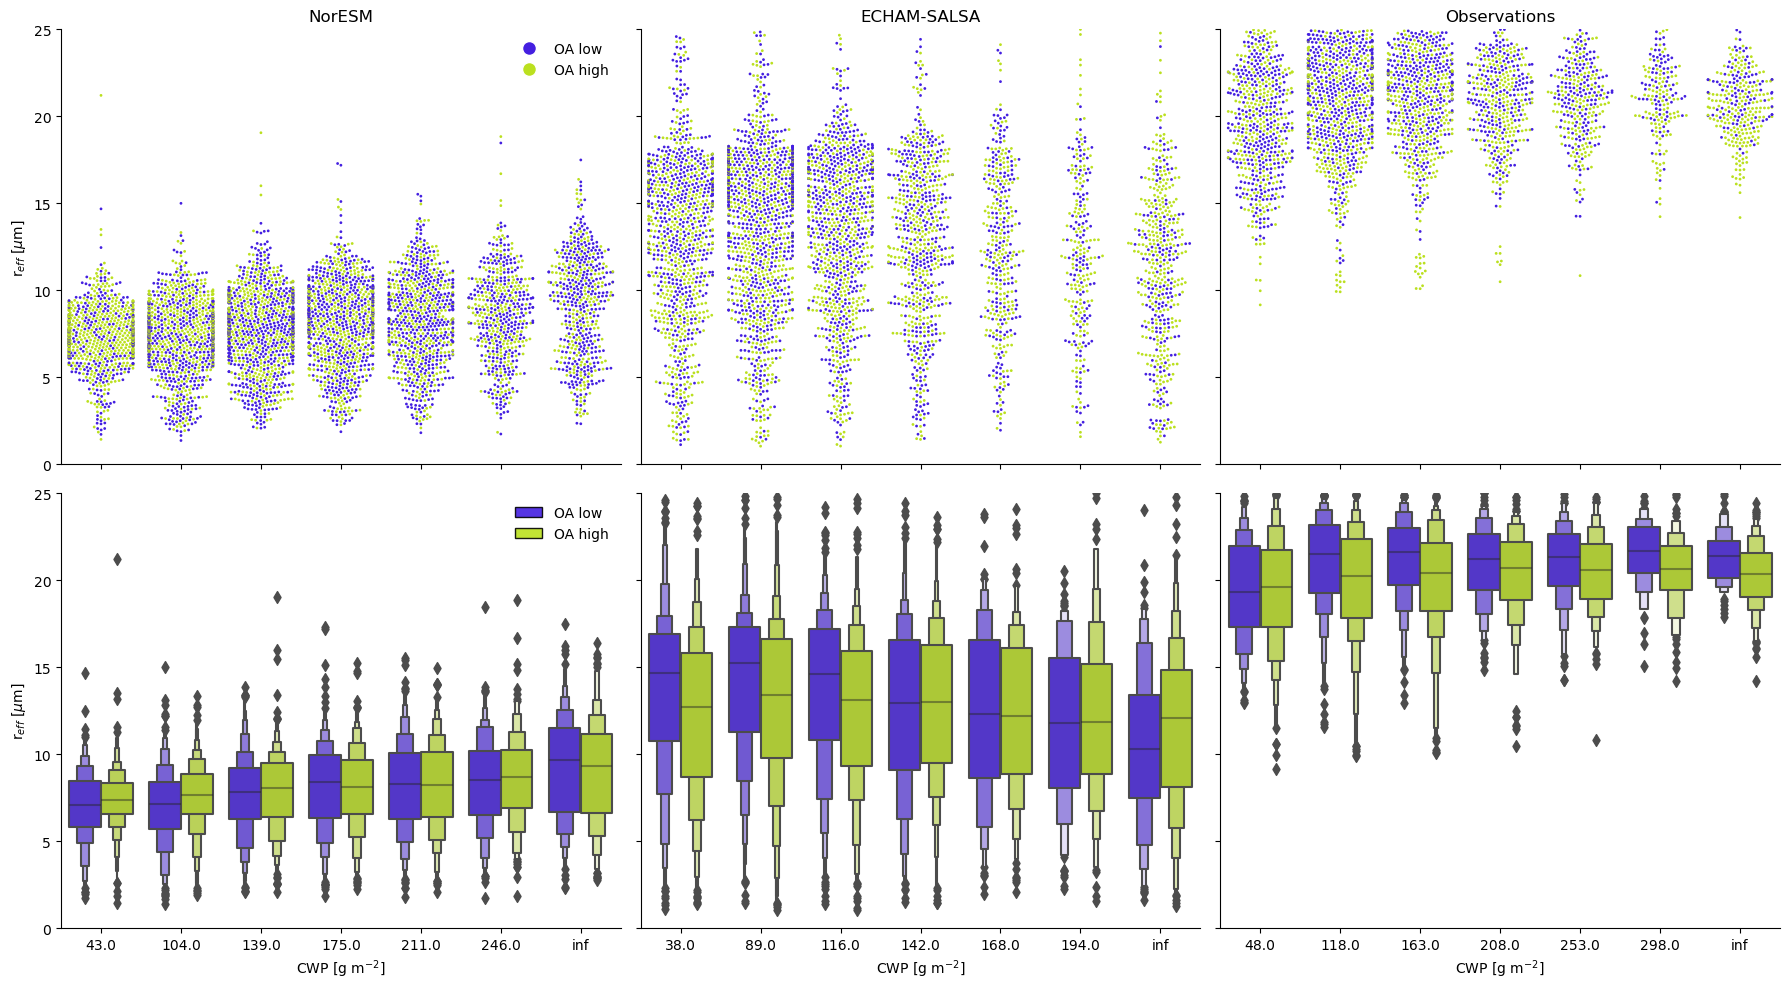

Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_MAM.png


In [132]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()
print(fn)
### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 37.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 34.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 23.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Plots/rel_plot/cloud_props_boxen_swarm_OA_category_r_eff_CWP_cut2lmid_MAM.png


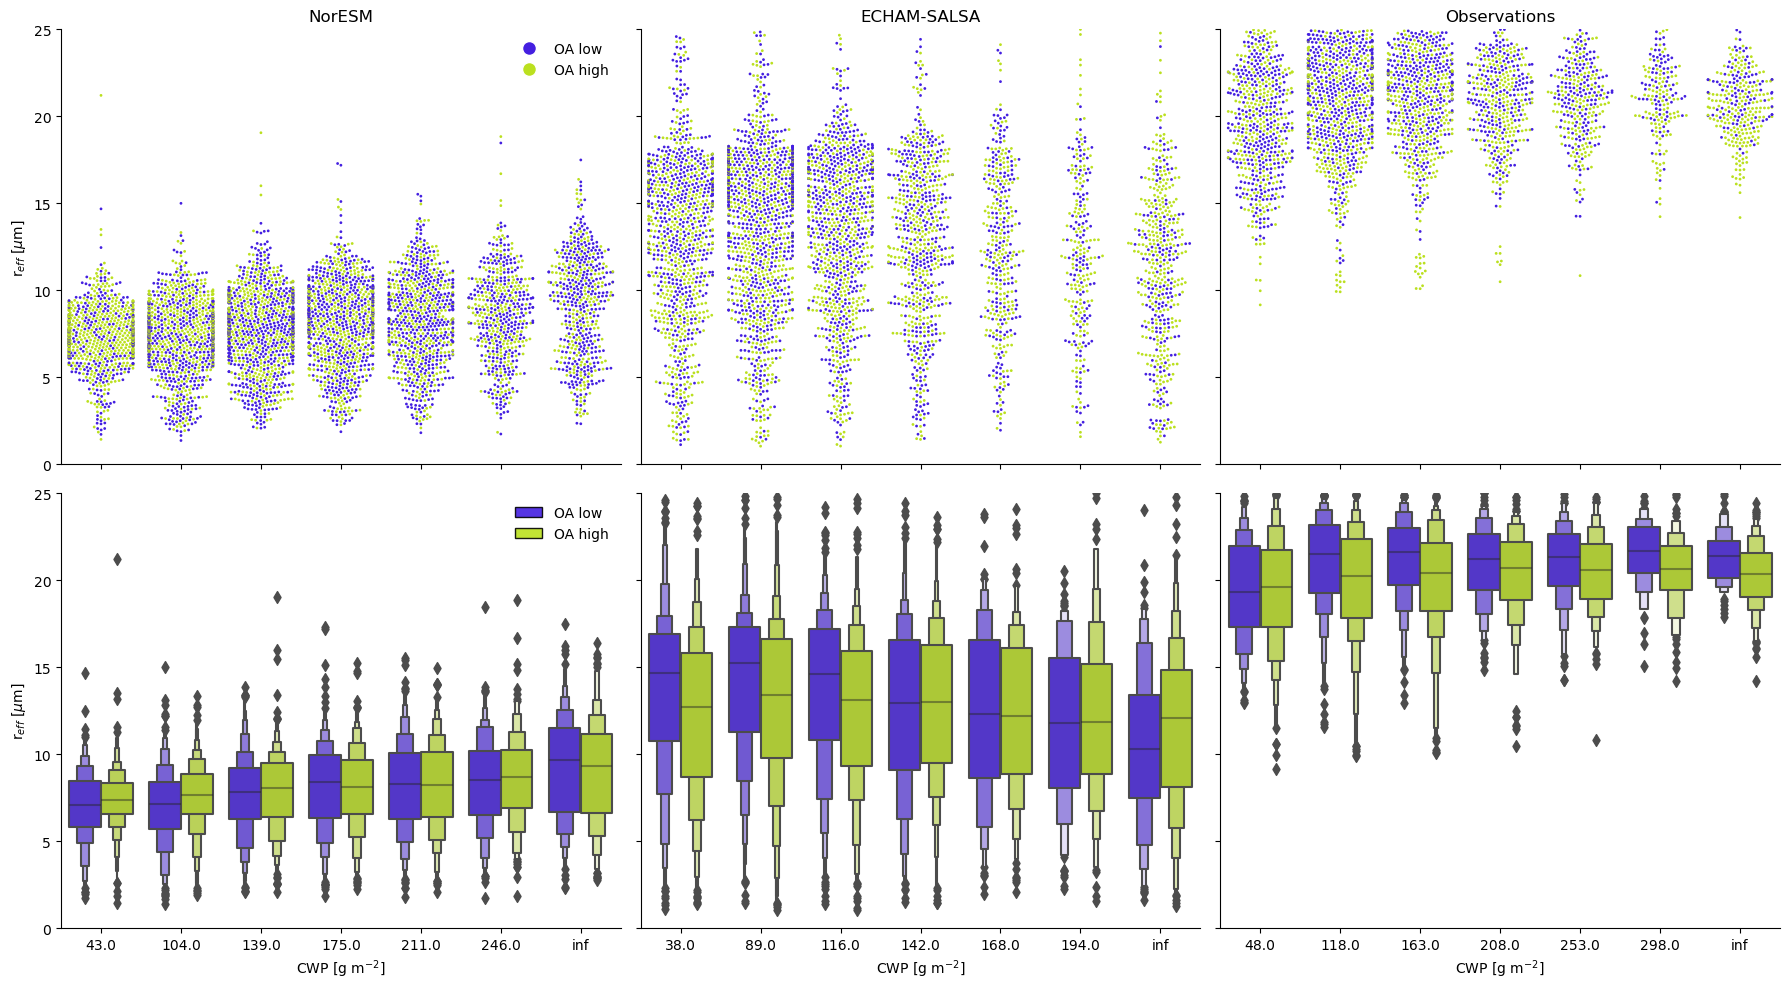

In [133]:
x_var = 'CWP_cut2lmid'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(order_keys, axs[0,:]):
#for key,ax in zip(dic_df.keys(), axs[0,:]):

    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(order_keys, axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

sns.despine(fig)
fn = make_fn(hue_var, y_var,x_var,comment='boxen_swarm', relplot=True)
print(fn) 
#fig.savefig(fn, dpi=150)
fig.tight_layout()
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
plt.show()

### Grid box avg

## Distribution of bootstrap median differences

In [134]:
x_var = 'CWP_cutlm'
y_var='COT'
itterations = 50000
for key in dic_df.keys():
    
    _df = dic_df[key].copy()
    
    _df_lim =_df.copy() 
    notna = (_df_lim[x_var].notna() & _df_lim[y_var].notna())&(_df_lim[hue_var].notna())
    _df_lim = _df_lim[notna]
    
    _df_low = _df_lim[_df_lim[hue_var] == hue_labs[0]]
    _df_high = _df_lim[_df_lim[hue_var] == hue_labs[1]]
        
        
    df_sample_med =bootstrap_subset(_df_low,_df_high, 
                               #quantiles = None,
                               var=y_var, category=x_var, itts=itterations)

    
    
    for ca in df_sample_med.columns:
        df_sample_med[ca].plot.hist(alpha=0.5, label=ca, bins=100)
    plt.title(key)
    plt.legend()
    
    plt.show()

length of 68 is 660 and 614
number of days is 183 and 213


KeyboardInterrupt: 